In [23]:
import numpy as np
from foe_foundry_nl.data.monsters import get_canonical_monsters, name_to_key
from foe_foundry.creature_types import CreatureType
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from pathlib import Path
import json as json
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd


sns.set_style("whitegrid")
sns.set_palette("hls", len(CreatureType.all()))

Text(0.5, 1.0, 'SentenceTransformer Embeddings of All Monsters')

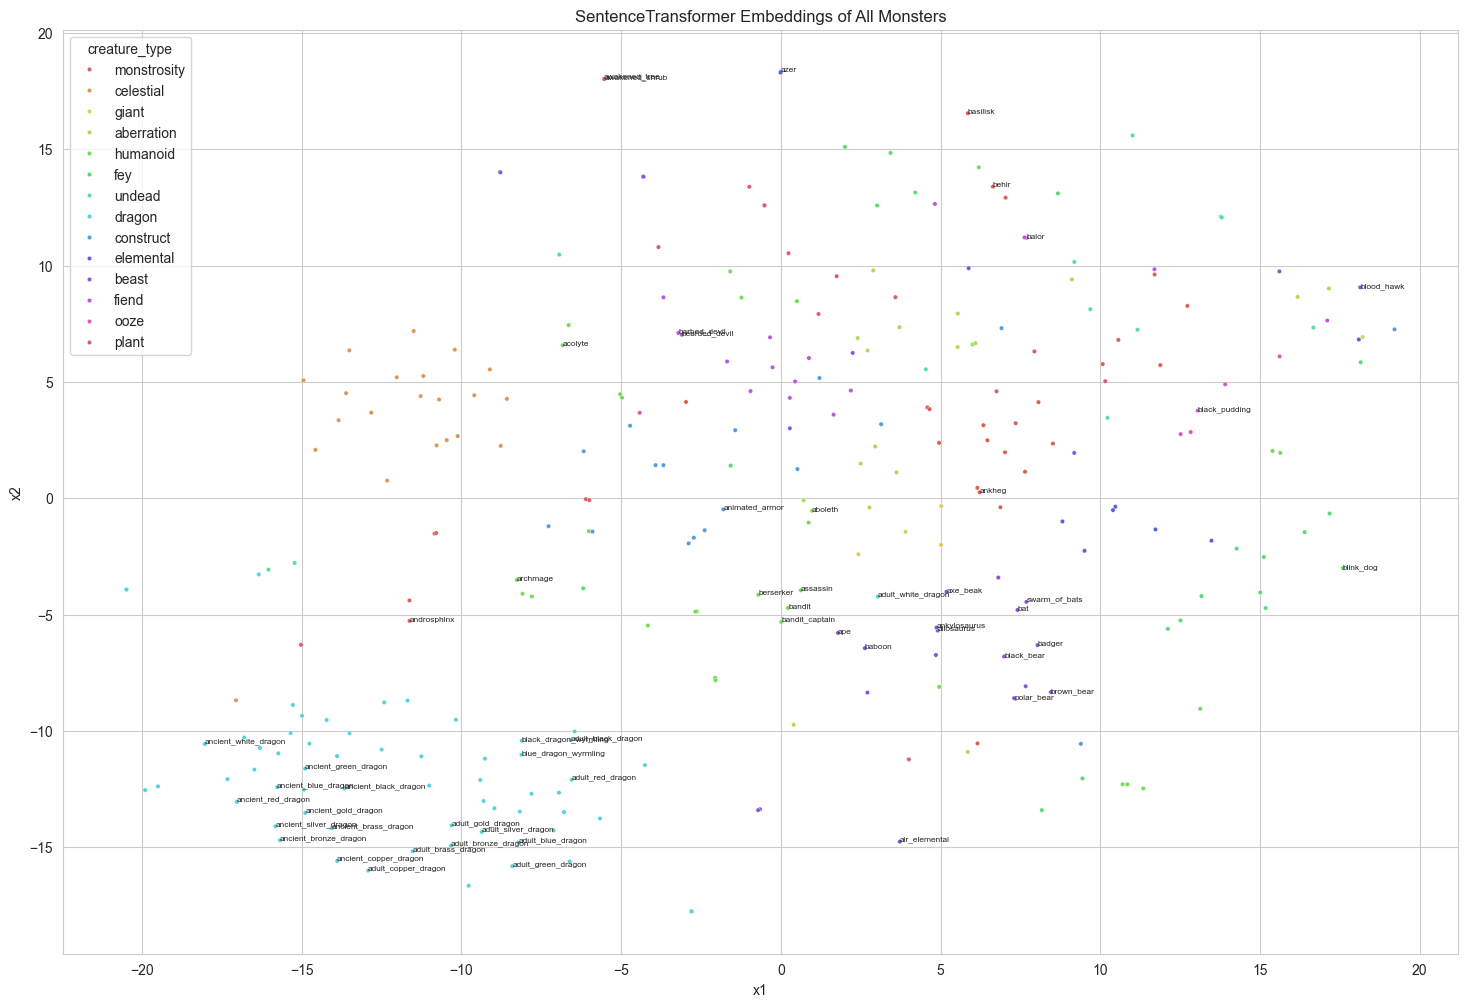

In [25]:
model = SentenceTransformer("msmarco-distilbert-base-v4")
all_monsters = get_canonical_monsters()
data_dir = Path.cwd().parent / "data" / "5e_nl2"

monsters = []
embeddings = []
test_queries = []
monster_types = []

for file in data_dir.glob("*.json"):
    monster_data: dict = json.loads(file.read_text())

    monster_name = monster_data["name"]
    monster_key = name_to_key(monster_name)
    monster_types.append(CreatureType.parse(monster_data["creature_type"]))
    queries = monster_data.pop("test_queries")
    for query in queries:
        test_queries.append((query, monster_name))

    text = json.dumps(monster_data, indent=4)
    document_embedding = model.encode(text)

    monsters.append(monster_key)
    embeddings.append(document_embedding)


monsters = np.array(monsters, dtype=str)
embeddings = np.asarray(embeddings, dtype=np.float32)


tsne = TSNE(n_components=2, random_state=20240711)
X = tsne.fit_transform(embeddings)

x1, x2 = X[:, 0], X[:, 1]

df = pd.DataFrame([
    pd.Series(x1, name='x1'),
    pd.Series(x2, name='x2'),
    pd.Series(monster_types, name='creature_type')
]).T

fig, ax = plt.subplots(1,1, figsize=(18,12))
sns.scatterplot(
    data=df,
    x='x1',
    y='x2',
    hue='creature_type',
    ax=ax,
    s=10
)

for i, key in enumerate(monsters):
    monster = all_monsters.get(key)
    if monster is not None and monster.is_srd:
        ax.annotate(monster.key, (x1[i], x2[i]), size=6)

ax.set_title("SentenceTransformer Embeddings of All Monsters")



In [26]:
for query, answer in test_queries:
    query_embedding = model.encode(query)
    similarities = util.cos_sim(query_embedding, embeddings).flatten().numpy()

    indexes = np.argsort(similarities)[::-1]
    closest_indexes = indexes[:5]

    print(f"Query: {query}")
    print(f"Answer: {answer}")
    for closest_index in closest_indexes:
        monster_name = monsters[closest_index]
        print(f"  Closest monster: {monster_name} ({similarities[closest_index]:.2f})")
    print("\n")


Query: amphibious monster
Answer: Aalpamac
  Closest monster: alligator (0.39)
  Closest monster: alligator_turtle (0.37)
  Closest monster: ankylosaurus (0.36)
  Closest monster: blemmyes (0.36)
  Closest monster: adult_sea_dragon (0.34)


Query: creature with distance distortion aura
Answer: Aalpamac
  Closest monster: aalpamac (0.61)
  Closest monster: aural_hunter (0.46)
  Closest monster: amethyst_dragon_wyrmling (0.44)
  Closest monster: ahu_nixta_mechanon (0.41)
  Closest monster: ashwalker (0.41)


Query: huge water beast
Answer: Aalpamac
  Closest monster: berberoka (0.47)
  Closest monster: adult_river_dragon (0.45)
  Closest monster: ancient_river_dragon (0.44)
  Closest monster: amphibolt (0.43)
  Closest monster: alpha_fish (0.42)


Query: monstrosity with strong melee attacks
Answer: Aalpamac
  Closest monster: alke (0.51)
  Closest monster: amphibolt (0.50)
  Closest monster: aniwye (0.50)
  Closest monster: bloody_bones (0.49)
  Closest monster: behir_magus (0.47)


Que